In [38]:
import warnings
import numpy as np
import pandas as pd
from math import floor, ceil
import os.path as op
from typing import List, Any, Callable, Literal, Optional, Union
from pandas.api.types import is_object_dtype
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu
from peregrin.scripts import PlotParams
import seaborn as sns
from itertools import combinations
import altair as alt
import plotly.graph_objects as go
from datetime import date




def _pick_encoding(path, encodings=("utf-8", "cp1252", "latin1", "iso8859_15")):
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False if enc != "utf-8" else True)
        except UnicodeDecodeError:
            continue

def _has_strings(s: pd.Series) -> bool:
    # pandas "string" dtype (pyarrow/python)
    if isinstance(s.dtype, pd.StringDtype):
        return s.notna().any()
    # categorical of strings?
    if isinstance(s.dtype, pd.CategoricalDtype):
        return isinstance(s.dtype.categories.dtype, pd.StringDtype) and s.notna().any()
    # numeric, datetime, bool, etc.
    if not is_object_dtype(s.dtype):
        return False
    # Fallback for object-dtype (mixed types): minimal Python loop over NumPy array
    arr = s.to_numpy(dtype=object, copy=False)
    return any(isinstance(v, (str, np.str_)) for v in arr)




In [40]:
TRACKS_DATAFRAME = pd.read_csv(r"C:\Users\modri\Desktop\Lab\Peregrin project\Nela's Poster Data\Track stats 2025-09-30 1.csv")
TRACKS_DATAFRAME['Track UID'] = np.arange(len(TRACKS_DATAFRAME))  # starts at 0
TRACKS_DATAFRAME.set_index('Track UID', drop=False, inplace=True, verify_integrity=True)

In [41]:
print(TRACKS_DATAFRAME.columns)

display(TRACKS_DATAFRAME)

Index(['Condition', 'Replicate', 'Track ID', 'Track length', 'Speed mean',
       'Speed median', 'Speed min', 'Speed max', 'Speed std',
       'Replicate color', 'Track displacement', 'Confinement ratio',
       'Direction mean (rad)', 'Direction std (rad)', 'Direction median (rad)',
       'Direction mean (deg)', 'Direction std (deg)', 'Direction median (deg)',
       'Track points', 'Track UID'],
      dtype='object')


,Condition,Replicate,Track ID,Track length,Speed mean,Speed median,Speed min,Speed max,Speed std,Replicate color,Track displacement,Confinement ratio,Direction mean (rad),Direction std (rad),Direction median (rad),Direction mean (deg),Direction std (deg),Direction median (deg),Track points,Track UID
Track UID,,,,,,,,,,,,,,,,,,,,
0,naive-ctr,BC42,193.0,36.201996,7.240399,5.867313,0.0,13.754366,5.321417,#e38963,16.600276,0.458546,-0.839858,0.835628,-1.072016,311.879655,47.877971,298.577991,5,0
1,naive-ctr,BC42,192.0,50.301511,8.383585,9.767937,0.0,14.525489,5.348922,#e38963,48.780166,0.969755,-2.775839,0.645587,-2.966628,200.956135,36.989384,190.024726,6,1
2,naive-ctr,BC42,191.0,14.596344,7.298172,7.298172,0.0,14.596344,10.321174,#e38963,14.596344,1.000000,-0.465343,0.893668,-0.465343,333.337812,51.203389,333.337812,2,2
3,naive-ctr,BC42,190.0,1.362382,0.681191,0.681191,0.0,1.362382,0.963349,#e38963,1.362382,1.000000,0.307119,0.953209,0.307119,17.596599,54.614831,17.596599,2,3
4,naive-ctr,BC42,189.0,15.949103,3.987276,4.169305,0.0,7.610493,3.276048,#e38963,1.476377,0.092568,-0.411204,0.465626,-0.628098,336.439750,26.678377,324.012637,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18383,memory-cxcl12-mu,BC39,4.0,169.155036,6.505963,4.601513,0.0,28.090184,5.758359,#ff7e47,3.276158,0.019368,0.813414,0.373777,0.626426,46.605173,21.415827,35.891544,26,18383
18384,memory-cxcl12-mu,BC39,3.0,339.126228,9.689321,9.529596,0.0,21.840772,5.944304,#ff7e47,57.324707,0.169036,1.398526,0.246951,1.250400,80.129632,14.149231,71.642650,35,18384
18385,memory-cxcl12-mu,BC39,2.0,361.574398,7.089694,6.238639,0.0,19.885587,4.388778,#ff7e47,169.454772,0.468658,-0.590720,0.426417,-0.411444,326.154220,24.431919,336.425994,51,18385


In [42]:
SPOTS_DATAFRAME = pd.read_csv(r"C:\Users\modri\Desktop\Lab\Peregrin project\Nela's Poster Data\Spot stats 2025-09-30-1.csv")
# print(SPOTS_DATAFRAME.columns)
# grp = SPOTS_DATAFRAME.groupby(['Condition', 'Replicate', 'Track ID'], sort=False)

# # ---- Add unique per-track index (1-based) ----
# SPOTS_DATAFRAME['Track UID'] = grp.ngroup()
SPOTS_DATAFRAME.set_index(['Track UID'], drop=False, append=False, inplace=True, verify_integrity=False)

print(SPOTS_DATAFRAME.columns)


Index(['Track ID', 'Time point', 'X coordinate', 'Y coordinate', 'Condition',
       'Replicate', 'Time unit', 'Track UID', 'Distance', 'Direction (rad)',
       'Cumulative track length', 'Cumulative track displacement',
       'Cumulative confinement ratio', 'Frame', 'Replicate color'],
      dtype='object')


In [43]:
# ---- replicate-aware palette pulled from df['Replicate color'] (with fallbacks) ----
def _build_replicate_palette(df, palette_fallback):
    reps = df['Replicate'].unique().tolist()
    mp = {}
    if 'Replicate color' in df.columns:
        mp = (df[['Replicate', 'Replicate color']]
                .dropna()
                .drop_duplicates('Replicate')
        )
        mp = mp.set_index('Replicate')['Replicate color'].to_dict()

    missing = [r for r in reps if r not in mp]
    if missing:
        cyc = sns.color_palette(palette_fallback, n_colors=len(missing))
        mp.update({r: cyc[i] for i, r in enumerate(missing)})

    return mp

    


In [44]:
def SetUnits(t: str) -> dict:
    return {
        "Track length": "(µm)",
        "Track displacement": "(µm)",
        "Confinement ratio": "",
        "Track points": "",
        "Speed mean": f"(µm·{t}⁻¹)",
        "Speed median": f"(µm·{t}⁻¹)",
        "Speed max": f"(µm·{t}⁻¹)",
        "Speed min": f"(µm·{t}⁻¹)",
        "Speed std": f"(µm·{t}⁻¹)",
        "Direction mean (deg)": "",
        "Direction mean (rad)": "",
        "Direction std (deg)": "",
        "Direction std (rad)": "",
    }

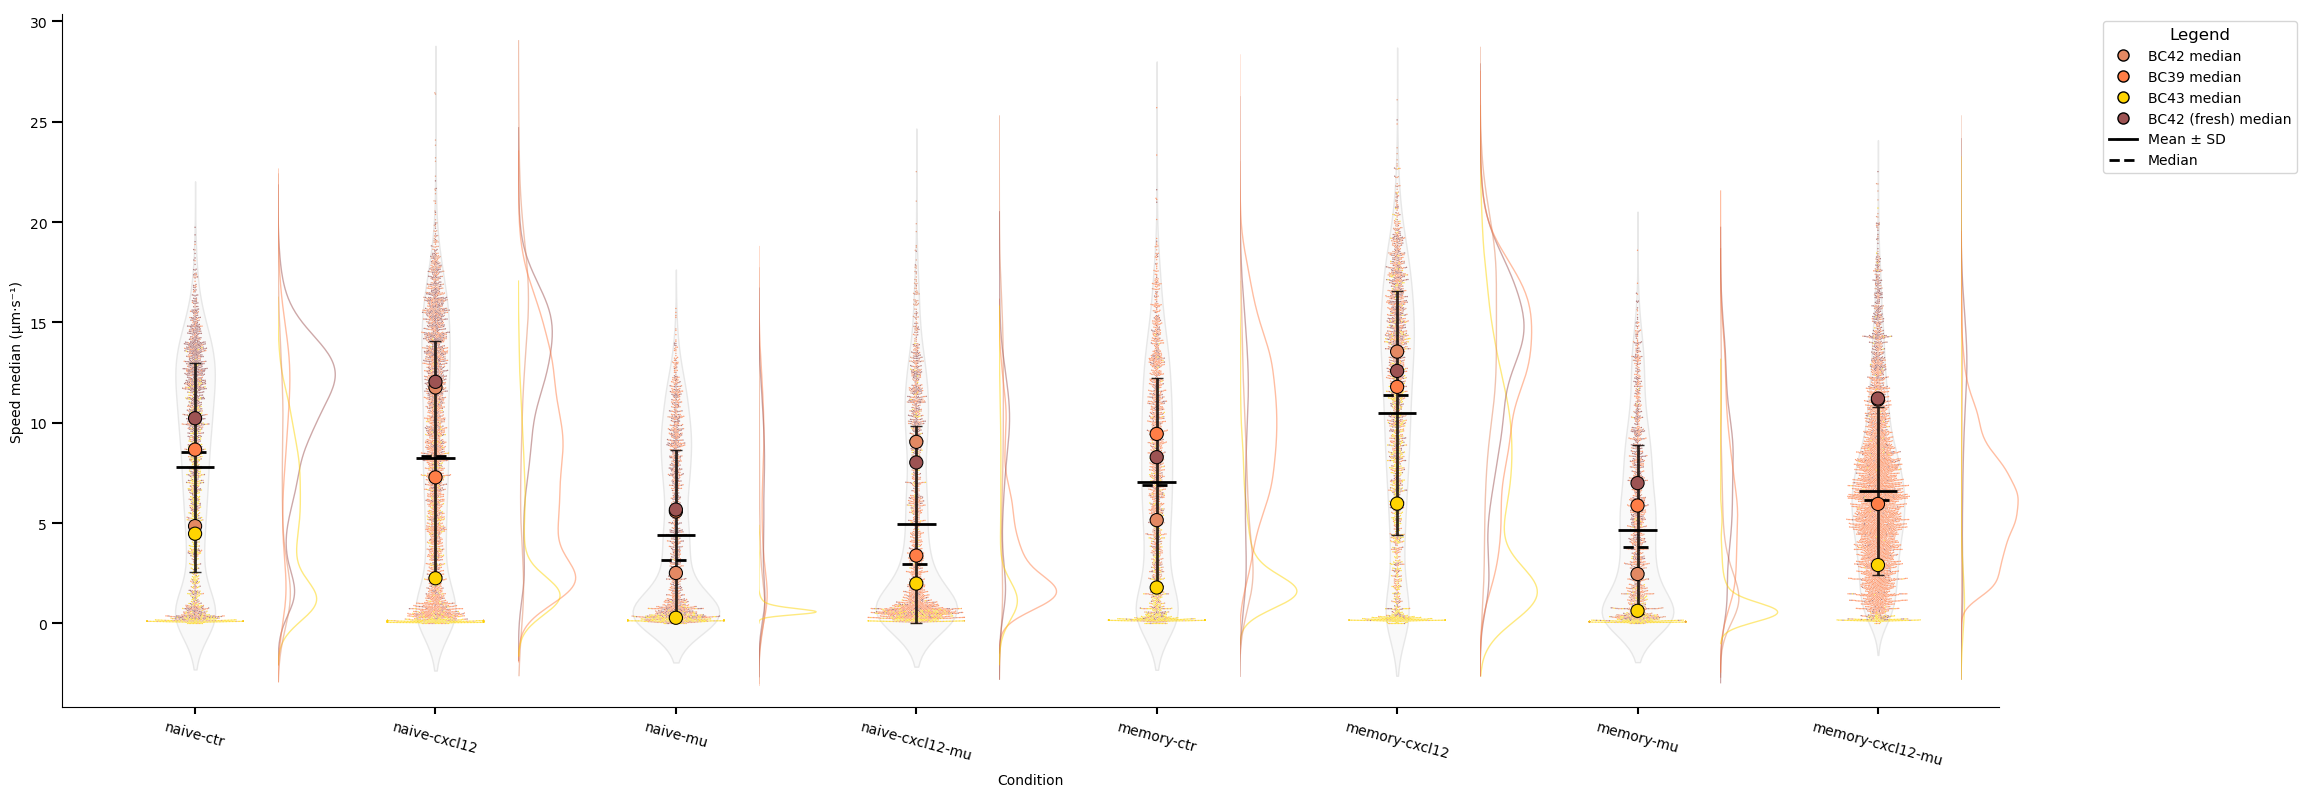

In [ ]:
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

def SwarmPlot(
    df: pd.DataFrame,
    metric: str,
    *args,
    title: str = '',
    palette: str = 'tab10',

    show_swarm: bool = True,
    swarm_size: int = 1,
    swarm_outline_color: str = 'black',
    swarm_alpha: float = 0.75,

    show_violin: bool = True,
    violin_fill_color: str = 'whitesmoke',
    violin_edge_color: str = 'lightgrey',
    violin_alpha: float = 0.5,
    violin_outline_width: float = 1,

    show_mean: bool = True,
    mean_span: float = 0.16,
    mean_color: str = 'black',
    mean_ls: str = '-',
    show_median: bool = True,
    median_span: float = 0.12,
    median_color: str = 'black',
    median_ls: str = '--',
    line_width: float = 2,

    show_error_bars: bool = True,
    errorbar_capsize: int = 4,
    errorbar_color: str = 'black',
    errorbar_lw: int = 2,
    errorbar_alpha: float = 0.8,

    show_mean_balls: bool = True,
    mean_ball_size: int = 90,
    mean_ball_outline_color: str = 'black',
    mean_ball_outline_width: float = 0.75,
    mean_ball_alpha: int = 1,
    show_median_balls: bool = False,
    median_ball_size: int = 70,
    median_ball_outline_color: str = 'black',
    median_ball_outline_width: float = 0.75,
    median_ball_alpha: int = 1,

    show_kde: bool = False,
    kde_inset_width: float = 0.5,
    kde_outline: float = 1,
    kde_alpha: float = 0.5,
    kde_fill: bool = False,

    show_legend: bool = True,
    show_grid: bool = False,
    open_spine: bool = True,

    plot_width: int = 20,
    plot_height: int = 9,
):
    """
    Faster drop-in SwarmPlot: same params and visuals (mean/median lines,
    error bars, violins, swarm, replicate markers, optional KDE insets).
    """

    plt.figure(figsize=(plot_width, plot_height))
    ax = plt.gca()

    if df is None or df.empty:
        return plt.gcf()

    _df = df.copy()

    # === condition order & optional spacers (for KDE layout) ===
    conditions = _df['Condition'].unique().tolist()

    if show_kde:
        spaced_conditions = ["spacer_0"] + list(
            chain.from_iterable(
                (cond, f"spacer_{i+1}") if i < len(conditions) - 1 else (cond,)
                for i, cond in enumerate(conditions)
            )
        )
        # Categorical with unobserved categories retained (order matters for aligning x)
        _df['Condition'] = pd.Categorical(_df['Condition'],
                                          categories=spaced_conditions,
                                          ordered=True)
        categories_for_stats = spaced_conditions
    else:
        _df['Condition'] = pd.Categorical(_df['Condition'],
                                          categories=conditions,
                                          ordered=True)
        categories_for_stats = conditions

    _palette = _build_replicate_palette(_df, palette_fallback=palette)

    # === stats (single pass) ===
    # keep all categories (observed=False) so spacers appear with NaNs
    _cond_stats = (
        _df.groupby('Condition', observed=False)[metric]
           .agg(mean='mean', median='median', std='std', count='count')
           .reindex(categories_for_stats)        # align to category order
           .reset_index()
    )
    _rep_stats = (
        _df.groupby(['Condition', 'Replicate'], observed=False)[metric]
           .agg(mean='mean', median='median')
           .reset_index()
    )

    # === base layers (seaborn handles packing/jitter efficiently) ===
    if show_swarm:
        sp = sns.swarmplot(
            data=_df,
            x="Condition",
            y=metric,
            hue='Replicate',
            palette=_palette,
            size=swarm_size,
            edgecolor=swarm_outline_color,
            dodge=False,
            alpha=swarm_alpha,
            legend=False,
            zorder=1,
            ax=ax,
        )

    if show_violin:
        sns.violinplot(
            data=_df,
            x='Condition',
            y=metric,
            color=violin_fill_color,
            edgecolor=violin_edge_color if violin_edge_color else None,
            linewidth=violin_outline_width,   # (seaborn uses 'linewidth')
            inner=None,
            gap=0.1,
            alpha=violin_alpha,
            zorder=0,
            ax=ax,
        )

    # === replicate mean/median markers (single scatter each) ===
    if show_mean_balls:
        sns.scatterplot(
            data=_rep_stats,
            x='Condition', y='mean',
            hue='Replicate',
            palette=_palette,
            edgecolor=mean_ball_outline_color,
            s=mean_ball_size,
            legend=False,
            alpha=mean_ball_alpha,
            linewidth=mean_ball_outline_width,
            zorder=4,
            ax=ax,
        )

    if show_median_balls:
        sns.scatterplot(
            data=_rep_stats,
            x='Condition', y='median',
            hue='Replicate',
            palette=_palette,
            edgecolor=median_ball_outline_color,
            s=median_ball_size,
            legend=False,
            alpha=median_ball_alpha,
            linewidth=median_ball_outline_width,
            zorder=4,
            ax=ax,
        )

    # === vectorized lines & error bars (big win) ===
    # Build x centers as 0..N-1 in category order (seaborn does the same internally)
    n = len(categories_for_stats)
    x_centers = np.arange(n)

    # Mask out spacers so we don't draw stats on them
    is_spacer = _cond_stats['Condition'].astype(str).str.startswith('spacer')
    valid = ~is_spacer

    y_mean = _cond_stats.loc[valid, 'mean'].to_numpy()
    y_median = _cond_stats.loc[valid, 'median'].to_numpy()
    y_std = _cond_stats.loc[valid, 'std'].to_numpy()
    x_valid = x_centers[valid.to_numpy()]

    # Mean & median short spans using vectorized hlines
    if show_mean and y_mean.size:
        xmin = x_valid - mean_span
        xmax = x_valid + mean_span
        ax.hlines(y_mean, xmin, xmax,
                  colors=mean_color, linestyles=mean_ls,
                  linewidths=line_width, zorder=3, label='Mean')

    if show_median and y_median.size:
        xmin_m = x_valid - median_span
        xmax_m = x_valid + median_span
        # If both present, only label once (matplotlib de-dupes identical labels later)
        ax.hlines(y_median, xmin_m, xmax_m,
                  colors=median_color, linestyles=median_ls,
                  linewidths=line_width, zorder=3,
                  label=('Median' if not show_mean else None))

    if show_error_bars and y_mean.size:
        ax.errorbar(
            x_valid, y_mean, yerr=y_std,
            fmt='none',
            color=errorbar_color,
            alpha=errorbar_alpha,
            linewidth=errorbar_lw,
            capsize=errorbar_capsize,
            zorder=3,
            label=('Mean ± SD' if (show_mean or show_median) else 'SD')
        )

    # === KDE insets (loop only once per actual condition) ===
    if show_kde:
        # After base layers, use established y-limits to size insets
        y_ax_min, y_ax_max = ax.get_ylim()

        # Iterate over actual conditions (even positions in spaced layout)
        for i, cond in enumerate(conditions):
            group_df = _df[_df['Condition'] == cond]
            if group_df.empty:
                continue

            # inset geometry in data coords
            x_pos = 2 * i + 2  # even positions: 0,2,4...
            offset_x = 0.31
            inset_height = y_ax_max - (y_ax_max - group_df[metric].max()) + abs(y_ax_min * 2)

            inset_ax = ax.inset_axes(
                [x_pos - offset_x, y_ax_min, kde_inset_width, inset_height],
                transform=ax.transData, zorder=0, clip_on=True
            )
            sns.kdeplot(
                data=group_df, y=metric, hue='Replicate',
                fill=kde_fill, alpha=kde_alpha, lw=kde_outline,
                palette=_palette, ax=inset_ax, legend=False,
                zorder=0, clip=(y_ax_min, y_ax_max),
            )
            # inset_ax.invert_xaxis()
            inset_ax.set_xticks([]); inset_ax.set_yticks([])
            inset_ax.set_xlabel(''); inset_ax.set_ylabel('')
            sns.despine(ax=inset_ax, left=True, bottom=True, top=True, right=True)

        # Ticks: show only real conditions
        ticks = [i for i, lbl in enumerate(categories_for_stats) if not str(lbl).startswith('spacer')]
        labels = [categories_for_stats[i] for i in ticks]
        plt.xticks(ticks=ticks, labels=labels)

    # === axes cosmetics (unchanged) ===
    plt.title(title)
    plt.xlabel("Condition")
    plt.ylabel(f"{metric} {SetUnits(t='s').get(metric)}")

    if show_legend:
        handles, labels = [], []

        # Replicate entries
        for r in _df['Replicate'].astype(str).unique().tolist():
            c = _palette.get(r, 'grey')
            handles.append(mlines.Line2D([], [], linestyle='None',
                                         marker='o', markersize=8,
                                         markerfacecolor=c,
                                         markeredgecolor='black',
                                         label=(str(r) + " median")))
            labels.append(str(r) + " median")

        # Stats entries (mirror your original logic)
        if show_mean and not show_error_bars:
            handles.append(mlines.Line2D([], [], color=mean_color,
                                         linestyle=mean_ls, linewidth=line_width,
                                         label='Mean'))
            labels.append('Mean')
        elif show_error_bars and not show_mean:
            handles.append(mlines.Line2D([], [], color=errorbar_color,
                                         linestyle='-', linewidth=errorbar_lw,
                                         marker='_', markersize=10,
                                         label='SD'))
            labels.append('SD')
        elif show_mean and show_error_bars:
            handles.append(mlines.Line2D([], [], color=errorbar_color,
                                         linestyle='-', linewidth=errorbar_lw,
                                         marker='_', markersize=10,
                                         label='Mean ± SD'))
            labels.append('Mean ± SD')

        if show_median:
            handles.append(mlines.Line2D([], [], color=median_color,
                                         linestyle=median_ls, linewidth=line_width,
                                         label='Median'))
            labels.append('Median')

        leg = ax.legend(handles, labels, title='Legend',
                        title_fontsize=12, fontsize=10,
                        loc='upper right', bbox_to_anchor=(1.15, 1),
                        frameon=True)
        try:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except Exception:
            pass
    else:
        try:
            plt.legend().remove()
        except Exception:
            pass

    sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
    plt.tick_params(axis='y', which='major', length=7, width=1.5, direction='out', color='black')
    plt.tick_params(axis='x', which='major', length=5, width=1.5, direction='out', color='black', rotation=345)
    if show_grid:
        plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)
    else:
        plt.grid(False)

    # Keep your legend move safeguard
    try:
        if plt.gca().get_legend() is not None:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
    except Exception:
        try:
            ax = plt.gca()
            if plt.gca().get_legend() is not None:
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except Exception:
            pass

    plt.show()

# SwarmPlot(TRACKS_DATAFRAME, 'Speed median', show_kde=False)
SwarmPlot(TRACKS_DATAFRAME, 'Speed median', show_kde=True, plot_width=25)

In [53]:

def _generate_random_color():
    """
    Generate a random color in hexadecimal format.

    """

    r = np.random.randint(0, 255)   # Red LED intensity
    g = np.random.randint(0, 255)   # Green LED intensity
    b = np.random.randint(0, 255)   # Blue LED intensity

    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def _generate_random_grey():
    """
    Generate a random grey color in hexadecimal format.

    """

    n = np.random.randint(0, 240)  # All LED intensities

    return '#{:02x}{:02x}{:02x}'.format(n, n, n)


def _make_cmap(elements, cmap):
    """
    Generate a qualitative colormap for a given list of elements.

    """

    n = len(elements)   # Number of elements in the dictionary
    if n == 0:          # Return an empty list if there are no elements
        return []       
    
    cmap = plt.get_cmap(cmap)                                   # Get the colormap
    colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]    # Generate a color for each element

    return colors


def _get_cmap(c_mode):
    """
    Get a colormap according to the selected color mode.

    """

    if c_mode == 'greyscale LUT':
        return plt.cm.gist_yarg
    elif c_mode == 'jet LUT':
        return plt.cm.jet
    elif c_mode == 'brg LUT':
        return plt.cm.brg
    elif c_mode == 'hot LUT':
        return plt.cm.hot
    elif c_mode == 'gnuplot LUT':
        return plt.cm.gnuplot
    elif c_mode == 'viridis LUT':
        return plt.cm.viridis
    elif c_mode == 'rainbow LUT':
        return plt.cm.rainbow
    elif c_mode == 'turbo LUT':
        return plt.cm.turbo
    elif c_mode == 'nipy_spectral LUT':
        return plt.cm.nipy_spectral
    elif c_mode == 'gist_ncar LUT':
        return plt.cm.gist_ncar
    else:
        return None


def _assign_marker(value, markers):
    """
    Qualitatively map a metric's percentile value to a symbol.

    """

    lut = []    # Initialize a list to store the ranges and corresponding symbols

    for key, val in markers.items():                # Iterate through the markers dictionary
        low, high = map(float, key.split('-'))      # Split the key into low and high values
        lut.append((low, high, val))                # Append the range and symbol to the list

    for low, high, symbol in lut:               # Return the symbol for the range that contains the given value
        if low <= value < high:                  # Check if the value falls within the range
            return symbol
    
    return list(markers.items())[-1][-1]            # Return the last symbol for thr 100th percentile (which is not included in the ranges)


def _get_markers(markers):
    """
    Get the markers according to the selected mode.

    """

    if markers == 'cell':
        return _cell
    elif markers == 'scaled':
        return _scaled
    elif markers == 'trains':
        return _trains
    elif markers == 'random':
        return _random
    elif markers == 'farm':
        return _farm
    elif markers == 'safari':
        return _safari
    elif markers == 'insects':
        return _insects
    elif markers == 'birds':
        return _birds
    elif markers == 'forest':
        return _forest
    elif markers == 'aquarium':
        return _aquarium

In [54]:
def _get_cmap(c_mode):
    c_mode = c_mode.replace("nipy-spectral", "nipy_spectral")
    if c_mode == 'greyscale LUT': return plt.cm.gist_yarg
    elif c_mode == 'jet LUT': return plt.cm.jet
    elif c_mode == 'brg LUT': return plt.cm.brg
    elif c_mode == 'hot LUT': return plt.cm.hot
    elif c_mode == 'gnuplot LUT': return plt.cm.gnuplot
    elif c_mode == 'viridis LUT': return plt.cm.viridis
    elif c_mode == 'rainbow LUT': return plt.cm.rainbow
    elif c_mode == 'turbo LUT': return plt.cm.turbo
    elif c_mode == 'nipy-spectral LUT': return plt.cm.nipy_spectral
    elif c_mode == 'gist-ncar LUT': return plt.cm.gist_ncar
    else: return None

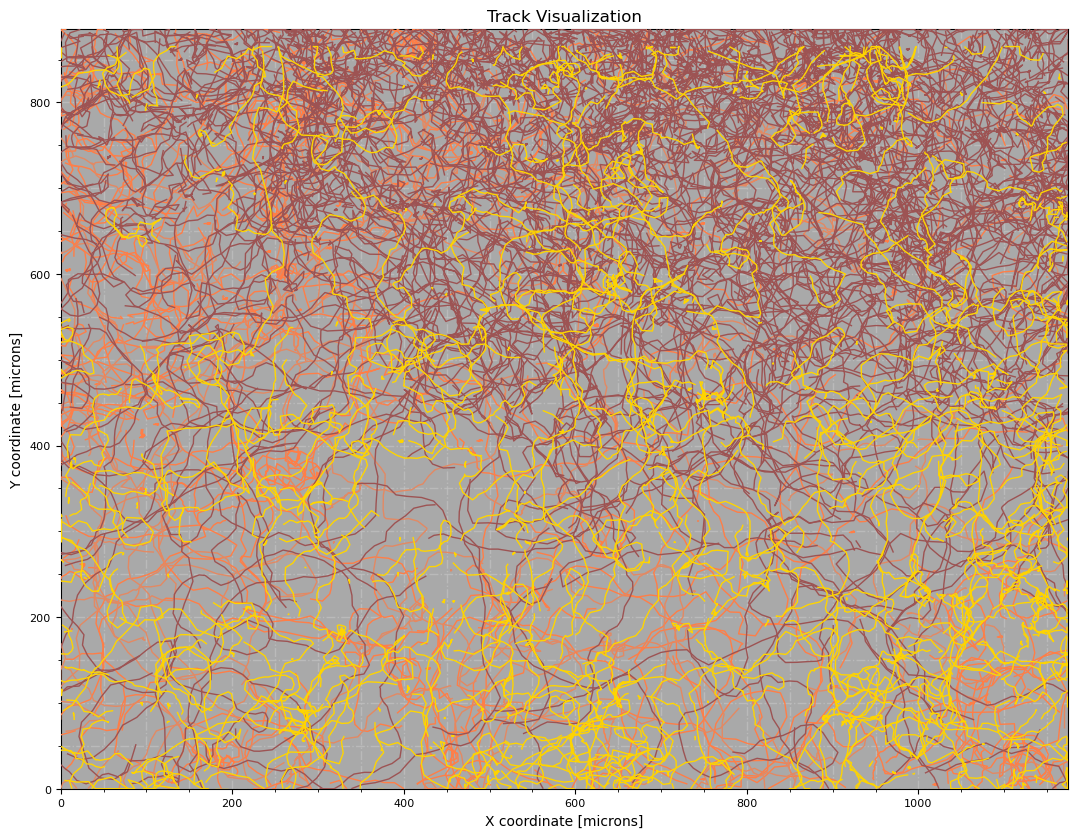

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def VisualizeTracks(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    condition: str,
    *args,
    replicate: str = 'all',
    c_mode: str = 'differentiate replicates',
    only_one_color: str = 'blue',
    lut_scaling_metric: str = 'Track displacement',
    background: str = 'dark',
    smoothing_index: int | float = 0,
    lw: float = 1.0,
    show_tracks: bool = True,
    grid: bool = True,
    arrows: bool = False,
    arrowsize: float = 5.0,
):
    # --- Early outs / guards -------------------------------------------------
    if not show_tracks:
        lw = 0

    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()
    
    # --- Filter & sort once ---------------------------------------------------
    required = ['Condition', 'Replicate', 'Track ID', 'Time point', 'X coordinate', 'Y coordinate', 'Replicate color']
    if any(col not in Spots.columns for col in required):
        return plt.gcf()

    if replicate == 'all':
        Spots = Spots.loc[Spots['Condition'] == condition]
        Tracks = Tracks.loc[Tracks['Condition'] == condition]
    elif replicate != 'all':
        Spots = Spots.loc[Spots['Replicate'] == replicate]
        Tracks = Tracks.loc[Tracks['Replicate'] == replicate]

    Spots = Spots.sort_values(['Condition', 'Replicate', 'Track ID', 'Time point'])
    Tracks = Tracks.sort_values(['Condition', 'Replicate', 'Track ID'])

    # Ensure we can group efficiently
    key_cols = ['Condition', 'Replicate', 'Track ID']

    # Ensure keys exist only as index (no duplicate columns)
    Spots = Spots.set_index(key_cols, drop=True)      # drop=True is the default; keeps keys out of columns
    Tracks = Tracks.set_index(key_cols, drop=True)

    # --- Optional smoothing (vectorized) --------------------------------------
    if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
        win = int(smoothing_index)
        Spots['X coordinate'] = (
            Spots.groupby(level=key_cols)['X coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        )
        Spots['Y coordinate'] = (
            Spots.groupby(level=key_cols)['Y coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        )

    # --- Colors: compute once, map to each track ------------------------------
    rng = np.random.default_rng(42)

    def rand_color():
        return mcolors.to_hex(rng.random(3))
    def rand_grey():
        g = float(rng.random())
        return mcolors.to_hex((g, g, g))

    colormap = None
    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        # one color per *track*
        unique_tracks = Tracks.index.unique()
        if c_mode == 'random colors':
            colors = [rand_color() for _ in range(len(unique_tracks))]
        elif c_mode == 'random greys':
            colors = [rand_grey() for _ in range(len(unique_tracks))]
        else:
            colors = [only_one_color] * len(unique_tracks)
        track_to_color = dict(zip(unique_tracks, colors))
        Tracks['Track color'] = [track_to_color[idx] for idx in Tracks.index]

    elif c_mode == 'differentiate replicates':
        Tracks['Track color'] = Tracks['Replicate color'] if 'Replicate color' in Tracks.columns else "black"

    else:
        # interpret c_mode as a matplotlib cmap name
        colormap = plt.get_cmap(c_mode)
        vmin = float(Tracks[lut_scaling_metric].min())
        vmax = float(Tracks[lut_scaling_metric].max())
        norm = plt.Normalize(vmin, vmax)
        Tracks['Track color'] = [mcolors.to_hex(colormap(norm(v))) for v in Tracks[lut_scaling_metric].to_numpy()]

    # Map per-track color down to Spots (single join; vectorized)
    # Replace the ambiguous join with this:
    Spots = Spots.join(
        Tracks[['Track color']],
        on=['Condition', 'Replicate', 'Track ID'],
        how='left',
        validate='many_to_one',
    )
    # --- Build line segments for LineCollection -------------------------------
    # Each segment is an array of shape (Ni, 2) for a track
    segments = []
    seg_colors = []
    # Using groupby over MultiIndex is still C-optimized; the loop is per-track (not per-point)
    for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
        xy = g[['X coordinate', 'Y coordinate']].to_numpy(dtype=float, copy=False)
        if xy.shape[0] >= 2:
            segments.append(xy)
            seg_colors.append(g['Track color'].iloc[0])

    # --- Figure / axes setup ---------------------------------------------------
    if background == 'light':
        grid_color, face_color, grid_alpha, grid_ls = 'gainsboro', 'white', 0.5, '-.' if grid else 'None'
    else:
        grid_color, face_color, grid_alpha, grid_ls = 'silver', 'darkgrey', 0.75, '-.' if grid else 'None'

    fig, ax = plt.subplots(figsize=(13, 10))
    if len(Spots):
        x = Spots['X coordinate'].to_numpy()
        y = Spots['Y coordinate'].to_numpy()
        ax.set_xlim(np.nanmin(x), np.nanmax(x))
        ax.set_ylim(np.nanmin(y), np.nanmax(y))

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X coordinate [microns]')
    ax.set_ylabel('Y coordinate [microns]')
    ax.set_title('Track Visualization', fontsize=12)
    ax.set_facecolor(face_color)
    ax.grid(grid, which='both', axis='both', color=grid_color, linestyle=grid_ls, linewidth=1, alpha=grid_alpha)

    # Ticks: use Locators/Formatters instead of setting ticklabels manually
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(axis='both', which='major', labelsize=8)

    # --- Draw all tracks at once ----------------------------------------------
    if segments:
        lc = LineCollection(segments, colors=seg_colors, linewidths=lw if show_tracks else 0, zorder=10)
        ax.add_collection(lc)

    # --- Optional arrows (use quiver in one batch) ----------------------------
    if arrows:
        # Take the last two points of each track to estimate direction
        tails_x, tails_y, dxs, dys, c_arr = [], [], [], [], []
        # Vectorized-ish: one pass per track (still cheap)
        for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
            arr = g[['X coordinate', 'Y coordinate']].to_numpy(dtype=float, copy=False)
            if arr.shape[0] >= 2:
                x0, y0 = arr[-2]
                x1, y1 = arr[-1]
                dx, dy = x1 - x0, y1 - y0
                tails_x.append(x0); tails_y.append(y0)
                dxs.append(dx); dys.append(dy)
                c_arr.append(g['Track color'].iloc[0])
        if tails_x:
            # Matplotlib quiver supports a single color or an array mapped via a colormap.
            # We add multiple quivers in chunks to preserve per-arrow colors efficiently.
            # (One large call per unique color is still fast.)
            tails_x = np.array(tails_x); tails_y = np.array(tails_y)
            dxs = np.array(dxs); dys = np.array(dys)
            c_arr = np.array(c_arr)
            for col in np.unique(c_arr):
                mask = c_arr == col
                ax.quiver(
                    tails_x[mask], tails_y[mask], dxs[mask], dys[mask],
                    angles='xy', scale_units='xy', scale=1,
                    width=0.003 * arrowsize, headlength=5*arrowsize, headaxislength=4*arrowsize, headwidth=4*arrowsize,
                    color=col, zorder=30
                )

    # return plt.gcf()
    plt.gcf()
    # plt.show()

VisualizeTracks(
    Spots_df=SPOTS_DATAFRAME, 
    Tracks_df=TRACKS_DATAFRAME,
    condition=TRACKS_DATAFRAME['Condition'].unique()[0],
    replicate='all',
    c_mode='differentiate replicates',
    # smoothing_index=5,
)

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def _prepare_tracks_with_colors(Spots_df, Tracks_df, condition, replicate,
                                c_mode, only_one_color, lut_scaling_metric):
    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()

    # filter once
    if replicate == 'all':
        Spots = Spots.loc[Spots['Condition'] == condition]
        Tracks = Tracks.loc[Tracks['Condition'] == condition]
    else:
        Spots = Spots.loc[Spots['Replicate'] == replicate]
        Tracks = Tracks.loc[Tracks['Replicate'] == replicate]

    # sort & index
    key_cols = ['Condition', 'Replicate', 'Track ID']
    Spots = Spots.sort_values(key_cols + ['Frame']).set_index(key_cols)
    Tracks = Tracks.sort_values(key_cols).set_index(key_cols)

    # colors once
    rng = np.random.default_rng(42)

    def rand_color(): return mcolors.to_hex(rng.random(3))
    def rand_grey():
        g = float(rng.random())
        return mcolors.to_hex((g, g, g))

    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        unique_tracks = Tracks.index.unique()
        if c_mode == 'random colors':
            colors = [rand_color() for _ in range(len(unique_tracks))]
        elif c_mode == 'random greys':
            colors = [rand_grey() for _ in range(len(unique_tracks))]
        else:
            colors = [only_one_color] * len(unique_tracks)
        track_to_color = dict(zip(unique_tracks, colors))
        Tracks['Track color'] = [track_to_color[idx] for idx in Tracks.index]
    elif c_mode == 'differentiate replicates':
        Tracks['Track color'] = Tracks['Replicate color'] if 'Replicate color' in Tracks.columns else "black"
    else:
        colormap = plt.get_cmap(c_mode)
        vmin = float(Tracks[lut_scaling_metric].min())
        vmax = float(Tracks[lut_scaling_metric].max())
        norm = plt.Normalize(vmin, vmax)
        Tracks['Track color'] = [mcolors.to_hex(colormap(norm(v))) for v in Tracks[lut_scaling_metric].to_numpy()]

    # single join to propagate per-track color to spots
    Spots = Spots.join(
        Tracks[['Track color']],
        on=Tracks.index.names,
        how='left',
        validate='many_to_one',
    )
    return Spots, Tracks

def _segments_for_frame(Spots_idxed, frame_value, key_cols=('Condition','Replicate','Track ID')):
    """Build segments up to and including `frame_value` in one pass."""
    segs, cols = [], []
    # Select only needed rows (fast boolean mask on a column)
    sub = Spots_idxed[Spots_idxed['Frame'] <= frame_value]

    # Group by track; each becomes one polyline up to that frame
    for _, g in sub.groupby(level=key_cols, sort=False):
        xy = g[['X coordinate','Y coordinate']].to_numpy(dtype=float, copy=False)
        if xy.shape[0] >= 2:
            segs.append(xy)
            cols.append(g['Track color'].iloc[0])
    return segs, cols

def visualize_tracks_frame(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    condition: str,
    *,
    replicate: str = 'all',
    c_mode: str = 'differentiate replicates',
    only_one_color: str = 'blue',
    lut_scaling_metric: str = 'Track displacement',
    background: str = 'dark',
    smoothing_index: int | float = 0,
    lw: float = 1.0,
    show_tracks: bool = True,
    grid: bool = True,
    frame_value: int = 0,
):
    if not show_tracks:
        lw = 0

    required = ['Condition','Replicate','Track ID','Frame','X coordinate','Y coordinate','Replicate color']
    if any(col not in Spots_df.columns for col in required if col!='Replicate color'):
        return plt.gcf()

    Spots, Tracks = _prepare_tracks_with_colors(
        Spots_df, Tracks_df, condition, replicate, c_mode, only_one_color, lut_scaling_metric
    )

    # Optional smoothing (vectorized; done once on the working table)
    if isinstance(smoothing_index, (int,float)) and smoothing_index > 1:
        win = int(smoothing_index)
        idx_names = ['Condition','Replicate','Track ID']
        Spots['X coordinate'] = Spots.groupby(level=idx_names)['X coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        Spots['Y coordinate'] = Spots.groupby(level=idx_names)['Y coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())

    segs, cols = _segments_for_frame(Spots, frame_value)

    # Figure/axes setup (cheap; we keep it minimal)
    if background == 'light':
        grid_color, face_color, grid_alpha, grid_ls = 'gainsboro', 'white', 0.5, '-.' if grid else 'None'
    else:
        grid_color, face_color, grid_alpha, grid_ls = 'silver', 'darkgrey', 0.75, '-.' if grid else 'None'

    fig, ax = plt.subplots(figsize=(13, 10))
    # Axis limits stable: compute once from *all* spots (gives no zoom jump)
    x = Spots_df.loc[Spots_df['Condition'] == condition, 'X coordinate'].to_numpy()
    y = Spots_df.loc[Spots_df['Condition'] == condition, 'Y coordinate'].to_numpy()
    if len(x) and len(y):
        ax.set_xlim(np.nanmin(x), np.nanmax(x))
        ax.set_ylim(np.nanmin(y), np.nanmax(y))

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X coordinate [microns]')
    ax.set_ylabel('Y coordinate [microns]')
    ax.set_title(f'Track Visualization — Frame {frame_value}', fontsize=12)
    ax.set_facecolor(face_color)
    ax.grid(grid, which='both', axis='both', color=grid_color, linestyle=grid_ls, linewidth=1, alpha=grid_alpha)

    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(axis='both', which='major', labelsize=8)

    if segs:
        lc = LineCollection(segs, colors=cols, linewidths=lw if show_tracks else 0, zorder=10)
        ax.add_collection(lc)

    return fig


In [ ]:
from shiny import App, ui, render, reactive

# Suppose you already have Spots_df, Tracks_df in memory.
# IMPORTANT: Ensure there is a 'Frame' column (int) in Spots_df.

def make_app(Spots_df: pd.DataFrame, Tracks_df: pd.DataFrame, default_condition: str):
    # establish frame range for the chosen condition (once)
    cond_mask = Spots_df['Condition'] == default_condition
    frame_min_val = Spots_df.loc[cond_mask, 'Frame'].min()
    frame_max_val = Spots_df.loc[cond_mask, 'Frame'].max()
    # Handle NaN gracefully
    frame_min = int(frame_min_val) if pd.notnull(frame_min_val) else 0
    frame_max = int(frame_max_val) if pd.notnull(frame_max_val) else 1

    app_ui = ui.page_sidebar(
        ui.sidebar(
            ui.input_slider("frame", "Frame", min=frame_min, max=frame_max, value=frame_min, step=1, ticks=False),
            ui.hr(),
            ui.input_select("replicate", "Replicate", choices=["all"] + sorted(Spots_df.loc[cond_mask, 'Replicate'].unique())),
            ui.input_select("c_mode", "Color mode", choices=[
                "differentiate replicates", "random colors", "random greys", "only-one-color", "viridis", "plasma", "magma"
            ], selected="differentiate replicates"),
            ui.input_text("only_one_color", "Only-one-color (hex or name)", value="blue"),
            ui.input_numeric("smooth", "Smoothing window", 0),
            ui.input_checkbox("grid", "Grid", True),
            width=300
        ),
        ui.card(
            ui.card_header("Visualize Tracks (scrub the frame slider)"),
            ui.output_plot("tracks_plot", fill=True, height="650px"),
        ),
        title="Frame-synchronized Track Viewer"
    )

    def server(input, output, session):

        @reactive.calc
        def opts():
            # package current settings
            return dict(
                replicate=input.replicate(),
                c_mode=input.c_mode(),
                only_one_color=input.only_one_color(),
                smoothing_index=input.smooth(),
                grid=input.grid(),
            )

        @render.plot
        def tracks_plot():
            o = opts()
            fig = visualize_tracks_frame(
                Spots_df=Spots_df,
                Tracks_df=Tracks_df,
                condition=default_condition,
                replicate=o["replicate"],
                c_mode=o["c_mode"],
                only_one_color=o["only_one_color"],
                background='dark',
                lut_scaling_metric='Track displacement',
                smoothing_index=o["smoothing_index"],
                lw=1.0,
                show_tracks=True,
                grid=o["grid"],
                frame_value=input.frame(),
            )
            return fig

    return App(app_ui, server)

app = make_app(
    Spots_df=SPOTS_DATAFRAME,
    Tracks_df=TRACKS_DATAFRAME,
    default_condition=TRACKS_DATAFRAME['Condition'].unique()[0]
)
app  # In Jupyter, just display the app object

: 

: 

In [ ]:
def Visualize_normalized_tracks_matplotlib(
        Spots_df: pd.DataFrame, 
        Tracks_df: pd.DataFrame, 
        condition: str, 
        *args,
        replicate: str = 'all', 
        c_mode: str = 'differentiate replicates', 
        only_one_color: str = 'blue', 
        lut_scaling_metric: str = 'Track displacement', 
        smoothing_index: float = 0, 
        lw: float = 1.0, 
        show_tracks: bool = True, 
        grid: bool = True, 
        arrows: bool = False, 
        arrowsize: int = 5
    ):

    arrow_length = 1  # Length of the arrow in data units

    # if 'level_0' in Tracks_df.columns:
    #     Tracks_df.drop(columns=['level_0'], inplace=True)
    
    # Tracks_df.reset_index(drop=False, inplace=True)


    sort_cols = ['Condition', 'Replicate', 'Track ID', 'Time point']
    missing_cols = [col for col in sort_cols if col not in Spots_df.columns]
    if not missing_cols:
        if condition == 'all':
            Spots_df = Spots_df.sort_values(by=sort_cols)
        elif condition != 'all' and replicate == 'all':
            Spots_df = Spots_df[Spots_df['Condition'] == condition].sort_values(by=sort_cols)
        elif condition != 'all' and replicate != 'all':
            Spots_df = Spots_df[(Spots_df['Condition'] == condition) & (Spots_df['Replicate'] == replicate)].sort_values(by=sort_cols)
    # else: skip sorting if columns are missing
    
    np.random.seed(42)  # For reproducibility
    
    # Set colors based on chosen mode
    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        colormap = None
        if c_mode == 'random colors':
            track_colors = [_generate_random_color() for _ in range(len(Tracks_df))]
        elif c_mode == 'random greys':
            track_colors = [_generate_random_grey() for _ in range(len(Tracks_df))]
        else:
            track_colors = [only_one_color for _ in range(len(Tracks_df))]
        
        color_map_direct = dict(zip(Tracks_df['Track ID'], track_colors))
        Tracks_df['Color'] = Tracks_df['Track ID'].map(color_map_direct)

    elif c_mode in ['differentiate conditions', 'differentiate replicates']:
        if c_mode == 'differentiate conditions':
            colormap = plt.get_cmap('Set1')  # Use qualitative colormap
            unique_vals = Spots_df['Condition'].unique()
            val_column = 'Condition'
        else:
            colormap = plt.get_cmap('Set1')
            unique_vals = Spots_df['Replicate'].unique()
            val_column = 'Replicate'

        # Assign colors to each unique category
        val_to_color = {
            val: colormap(i % colormap.N)  # Wrap around if more values than colors
            for i, val in enumerate(sorted(unique_vals))
        }
        # Map those colors to the tracks
        Tracks_df['Color'] = Tracks_df[val_column].map(val_to_color)

    else:
        colormap = _get_cmap(c_mode)
        metric_min = Spots_df[lut_scaling_metric].min()
        metric_max = Spots_df[lut_scaling_metric].max()


    Spots_grouped = Spots_df.groupby(['Condition', 'Replicate', 'Track ID'])
    Tracks_df.set_index(['Condition', 'Replicate', 'Track ID'], inplace=True)
    
    processed_groups = []

    # Normalize each track's positions to start at (0, 0)
    for (cond, repl, track), group_df in Spots_grouped:
        # Apply smoothing if required
        if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
            group_df['X coordinate'] = group_df['X coordinate'].rolling(window=int(smoothing_index), min_periods=1).mean()
            group_df['Y coordinate'] = group_df['Y coordinate'].rolling(window=int(smoothing_index), min_periods=1).mean()

        # Normalize positions to start at (0, 0)
        start_x = group_df['X coordinate'].iloc[0]
        start_y = group_df['Y coordinate'].iloc[0]

        group_df['X coordinate'] -= start_x
        group_df['Y coordinate'] -= start_y

        processed_groups.append(group_df)

    # Concatenate everything back into one DataFrame
    Spots_df = pd.concat(processed_groups)

    # Convert to polar coordinates.
    Spots_df['r'] = np.sqrt(Spots_df['X coordinate']**2 + Spots_df['Y coordinate']**2)
    Spots_df['theta'] = np.arctan2(Spots_df['Y coordinate'], Spots_df['X coordinate'])

    Spots_grouped = Spots_df.groupby(['Condition', 'Replicate', 'Track ID'])
    
    fig, ax = plt.subplots(figsize=(12.5, 9.5), subplot_kw={'projection': 'polar'})
    y_max = Spots_df['r'].max() * 1.1

    x_grid_color = 'grey'
    y_grid_color = 'lightgrey'
    ax.set_facecolor('white')

    ax.set_title('Normalized Tracks')
    ax.set_ylim(0, y_max)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(grid)
    

    # Plot all tracks along with an arrow at the track's end pointing toward the mean direction
    for (cond, repl, track), group_df in Spots_grouped:

        track_row = Tracks_df.loc[(cond, repl, track)]
        track_row['Condition'] = cond
        track_row['Replicate'] = repl
        track_row['Track ID'] = track

        if colormap is not None and c_mode in ['differentiate conditions', 'differentiate replicates']:
            key = track_row[val_column]  # val_column is either 'Condition' or 'Replicate'
            color = colormap(unique_vals.tolist().index(key) % colormap.N)  # consistent mapping
            group_df['Color'] = mcolors.to_hex(color)
            
        elif colormap is not None:
            # This is for metric-based color mapping (quantitative)
            norm = plt.Normalize(metric_min, metric_max)
            color = colormap(norm(track_row[lut_scaling_metric]))
            group_df['Color'] = mcolors.to_hex(color)
            
        elif c_mode in ['random colors', 'random greys']:
            group_df['Color'] = track_row['Color']

        elif c_mode == 'only-one-color':
            group_df['Color'] = only_one_color


        # Plot the track using computed color.
        ax.plot(group_df['theta'], group_df['r'], lw=lw, color=group_df['Color'].iloc[0])

        # If arrows flag is True, add an arrow at the end of the track.
        if arrows:
            # Get the last point of the current track.
            last_point = group_df.iloc[-1]
            r_end = last_point['r']
            theta_end = last_point['theta']

            # Get the mean direction from the track metadata (in radians)
            mean_dir = track_row['Direction mean (rad)']

            # Convert last point from polar to Cartesian coordinates.
            x_end = r_end * np.cos(theta_end)
            y_end = r_end * np.sin(theta_end)
            
            # Calculate the arrow tip in Cartesian coordinates using the mean direction.
            x_tip = x_end + arrow_length * np.cos(mean_dir)
            y_tip = y_end + arrow_length * np.sin(mean_dir)
            
            # Convert the computed Cartesian arrow tip back to polar coordinates.
            r_tip = np.sqrt(x_tip**2 + y_tip**2)
            theta_tip = np.arctan2(y_tip, x_tip)

            ax.annotate(
                '',
                xy=(theta_tip, r_tip),
                xytext=(theta_end, r_end),
                arrowprops=dict(arrowstyle='-|>', 
                color=group_df['Color'].iloc[0], 
                lw=lw if show_tracks else 0, 
                mutation_scale=arrowsize),
                annotation_clip=False
            )

    Tracks_df.reset_index(drop=False, inplace=True)

    # Style the polar grid.
    for i, line in enumerate(ax.get_xgridlines()):
        if i % 2 == 0:
            line.set_linestyle('--')
            line.set_color(x_grid_color)
            line.set_linewidth(0.5)

    for line in ax.get_ygridlines():
        line.set_linestyle('-.')
        line.set_color(y_grid_color)
        line.set_linewidth(0.5)

    return plt.gcf()

Visualize_normalized_tracks_matplotlib(
    Spots_df=SPOTS_DATAFRAME,
    Tracks_df=TRACKS_DATAFRAME,
    condition=TRACKS_DATAFRAME['Condition'].unique()[0],
)



ValueError: No objects to concatenate

: 

: 

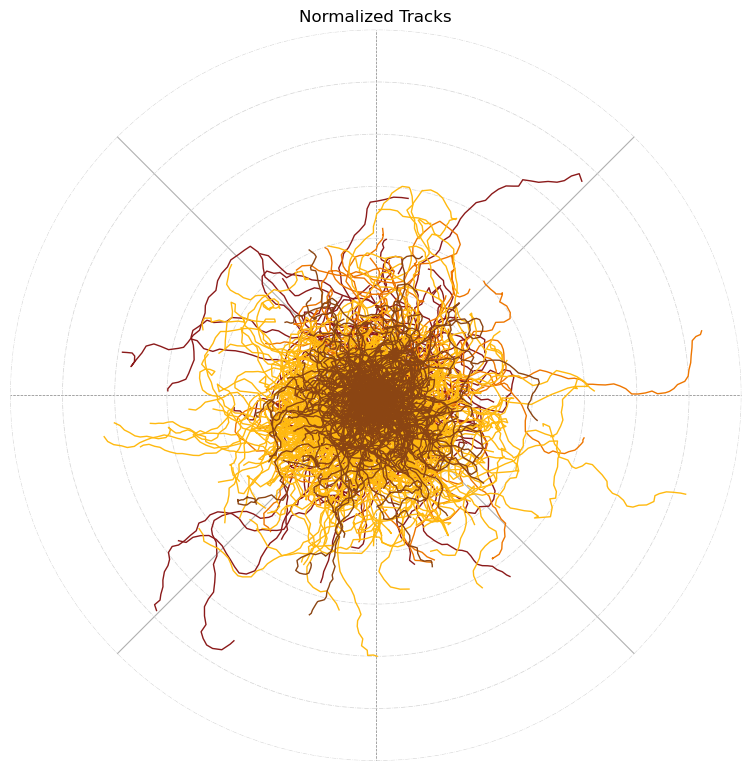

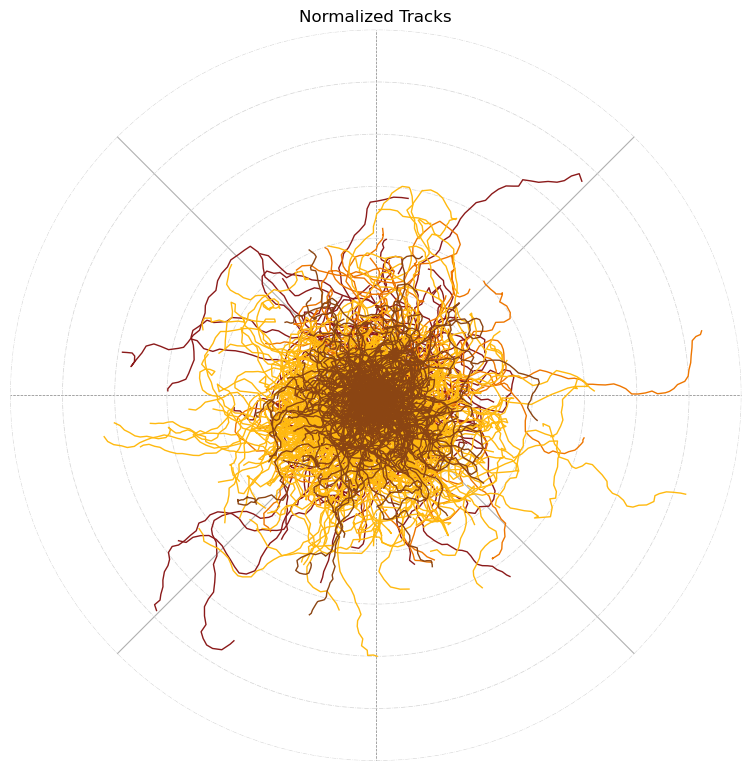

: 

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def _rand_hex_colors(n, rng):
    return [mcolors.to_hex(rng.random(3)) for _ in range(n)]

def _rand_hex_greys(n, rng):
    greys = rng.random(n)
    return [mcolors.to_hex((float(g), float(g), float(g))) for g in greys]

def Visualize_normalized_tracks_matplotlib(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    condition: str,
    *args,
    replicate: str = 'all',
    c_mode: str = 'differentiate replicates',
    only_one_color: str = 'blue',
    lut_scaling_metric: str = 'Track displacement',
    smoothing_index: float = 0,
    lw: float = 1.0,
    show_tracks: bool = True,
    grid: bool = True,
    arrows: bool = False,
    arrowsize: int = 5,
):
    """
    Fast, vectorized normalized (origin-shifted) polar track visualization.
    Mirrors VisualizeTracks logic:
      - single sort + groupby over MultiIndex
      - vectorized smoothing and normalization
      - consistent color-mapping, incl. 'differentiate replicates'
      - one-pass LineCollection draw in polar space
      - optional arrows (mean direction) drawn efficiently
    """

    

    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()

    # Required columns
    required_spots = ['Condition','Replicate','Track ID','Time point','X coordinate','Y coordinate']
    if any(col not in Spots.columns for col in required_spots):
        return plt.gcf()

    # --- Filter & sort once --------------------------------------------------
    if condition == 'all':
        if replicate != 'all':
            Spots = Spots.loc[Spots['Replicate'] == replicate]
            Tracks = Tracks.loc[Tracks['Replicate'] == replicate]
    else:
        Spots = Spots.loc[Spots['Condition'] == condition]
        Tracks = Tracks.loc[Tracks['Condition'] == condition]
        if replicate != 'all':
            Spots = Spots.loc[Spots['Replicate'] == replicate]
            Tracks = Tracks.loc[Tracks['Replicate'] == replicate]

    Spots = Spots.sort_values(['Condition','Replicate','Track ID','Time point'])
    Tracks = Tracks.sort_values(['Condition','Replicate','Track ID'])

    key_cols = ['Condition','Replicate','Track ID']

    # Index for efficient groupby/joins
    Spots = Spots.set_index(key_cols, drop=True)
    Tracks = Tracks.set_index(key_cols, drop=True)

    # --- Optional smoothing (vectorized over groups) -------------------------
    if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
        win = int(smoothing_index)
        Spots['X coordinate'] = Spots.groupby(level=key_cols)['X coordinate'] \
                                     .transform(lambda s: s.rolling(win, min_periods=1).mean())
        Spots['Y coordinate'] = Spots.groupby(level=key_cols)['Y coordinate'] \
                                     .transform(lambda s: s.rolling(win, min_periods=1).mean())

    # --- Normalize each track to start at (0,0) (vectorized) -----------------
    x0 = Spots.groupby(level=key_cols)['X coordinate'].transform('first')
    y0 = Spots.groupby(level=key_cols)['Y coordinate'].transform('first')
    Spots['Xn'] = Spots['X coordinate'] - x0
    Spots['Yn'] = Spots['Y coordinate'] - y0

    # --- Colors: compute once on Tracks, map to Spots ------------------------
    rng = np.random.default_rng(42)
    track_index = Tracks.index.unique()

    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        if c_mode == 'random colors':
            cols = _rand_hex_colors(len(track_index), rng)
        elif c_mode == 'random greys':
            cols = _rand_hex_greys(len(track_index), rng)
        else:
            cols = [mcolors.to_hex(only_one_color)] * len(track_index)
        color_map = dict(zip(track_index, cols))
        Tracks['Track color'] = [color_map[idx] for idx in Tracks.index]

    elif c_mode == 'differentiate replicates':
        # Use 'Replicate color' from Tracks when available; otherwise fallback to a stable random per replicate
        if 'Replicate color' in Tracks.columns:
            Tracks['Track color'] = Tracks['Replicate color'].astype(str)
        else:
            reps = Tracks.reset_index()['Replicate'].unique().tolist()
            rep_cols = _rand_hex_colors(len(reps), rng)
            rep2col = dict(zip(reps, rep_cols))
            Tracks = Tracks.reset_index()
            Tracks['Track color'] = Tracks['Replicate'].map(rep2col)
            Tracks = Tracks.set_index(key_cols)

    elif c_mode == 'differentiate conditions':
        conds = Tracks.reset_index()['Condition'].unique().tolist()
        cmap = plt.get_cmap('Set1')
        cond2col = {c: mcolors.to_hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(conds))}
        Tracks = Tracks.reset_index()
        Tracks['Track color'] = Tracks['Condition'].map(cond2col)
        Tracks = Tracks.set_index(key_cols)

    else:
        # Interpret c_mode as a Matplotlib colormap for quantitative mapping on Tracks
        cmap = plt.get_cmap(c_mode)
        vmin = float(Tracks[lut_scaling_metric].min()) if lut_scaling_metric in Tracks.columns else 0.0
        vmax = float(Tracks[lut_scaling_metric].max()) if lut_scaling_metric in Tracks.columns else 1.0
        norm = plt.Normalize(vmin, vmax)
        vals = Tracks[lut_scaling_metric].to_numpy() if lut_scaling_metric in Tracks.columns else np.zeros(len(Tracks))
        Tracks['Track color'] = [mcolors.to_hex(cmap(norm(v))) for v in vals]

    # Map per-track color to Spots (many-to-one join)
    Spots = Spots.join(
        Tracks[['Track color']],
        on=key_cols,
        how='left',
        validate='many_to_one',
    )

    # --- Polar conversion (vectorized) ---------------------------------------
    Spots['r'] = np.sqrt(Spots['Xn']**2 + Spots['Yn']**2)
    Spots['theta'] = np.arctan2(Spots['Yn'], Spots['Xn'])

    # --- Build segments per track for LineCollection in polar ----------------
    segments = []
    seg_colors = []
    for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
        # Assumes sorted by time already
        th = g['theta'].to_numpy(dtype=float, copy=False)
        rr = g['r'].to_numpy(dtype=float, copy=False)
        if th.size >= 2:
            # Nx2 path in polar coordinates: (theta, r)
            seg = np.column_stack([th, rr])
            segments.append(seg)
            seg_colors.append(g['Track color'].iloc[0])

    # --- Figure / axes setup --------------------------------------------------
    fig, ax = plt.subplots(figsize=(12.5, 9.5), subplot_kw={'projection': 'polar'})

    if len(Spots):
        y_max = float(np.nanmax(Spots['r'].to_numpy())) * 1.1
        if not np.isfinite(y_max) or y_max <= 0:
            y_max = 1.0
    else:
        y_max = 1.0

    ax.set_facecolor('white')
    ax.set_title('Normalized Tracks', fontsize=12)
    ax.set_ylim(0, y_max)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(grid)

    # --- Draw all tracks at once ---------------------------------------------
    if segments:
        lc = LineCollection(
            segments,
            colors=seg_colors,
            linewidths=lw if show_tracks else 0,
            zorder=10,
        )
        # VERY IMPORTANT: tell LC these are in data coords of the polar Axes
        lc.set_transform(ax.transData)
        ax.add_collection(lc)

    # --- Optional arrows (toward mean direction) -----------------------------
    if arrows and 'Direction mean (rad)' in Tracks.columns:
        # One arrow per track, using the last point as tail; tip = tail + arrow_length * mean_dir
        arrow_length = 1.0
        # Grab last point per track from Spots and mean dir from Tracks
        last_pts = Spots.groupby(level=key_cols, sort=False).tail(1).reset_index()
        mean_dir = Tracks.reset_index()[key_cols + ['Direction mean (rad)','Track color']]

        merged = pd.merge(last_pts, mean_dir, on=key_cols, how='left', validate='one_to_one')

        # Compute tip in Cartesian, then convert to polar
        xe = merged['Xn'].to_numpy()
        ye = merged['Yn'].to_numpy()
        md = merged['Direction mean (rad)'].to_numpy()
        cols = merged['Track color'].astype(str).to_numpy()

        xt = xe + arrow_length * np.cos(md)
        yt = ye + arrow_length * np.sin(md)

        tail_r = np.sqrt(xe**2 + ye**2)
        tail_th = np.arctan2(ye, xe)
        tip_r = np.sqrt(xt**2 + yt**2)
        tip_th = np.arctan2(yt, xt)

        # Draw in color chunks to minimize draw calls
        if tail_r.size:
            uniq_cols = np.unique(cols)
            for col in uniq_cols:
                m = (cols == col)
                for th0, r0, th1, r1 in zip(tail_th[m], tail_r[m], tip_th[m], tip_r[m]):
                    ax.annotate(
                        '',
                        xy=(th1, r1),
                        xytext=(th0, r0),
                        arrowprops=dict(
                            arrowstyle='-|>',
                            color=str(col),
                            lw=lw if show_tracks else 0,
                            mutation_scale=arrowsize,
                        ),
                        annotation_clip=False,
                    )

    # --- Style the polar grid (subtle alternating styles) --------------------
    for i, line in enumerate(ax.get_xgridlines()):
        if i % 2 == 0:
            line.set_linestyle('--')
            line.set_color('grey')
            line.set_linewidth(0.5)
    for line in ax.get_ygridlines():
        line.set_linestyle('-.')
        line.set_color('lightgrey')
        line.set_linewidth(0.5)

    return plt.gcf()

Visualize_normalized_tracks_matplotlib(
    Spots_df=SPOTS_DATAFRAME,
    Tracks_df=TRACKS_DATAFRAME,
    condition=TRACKS_DATAFRAME['Condition'].unique()[0],
)

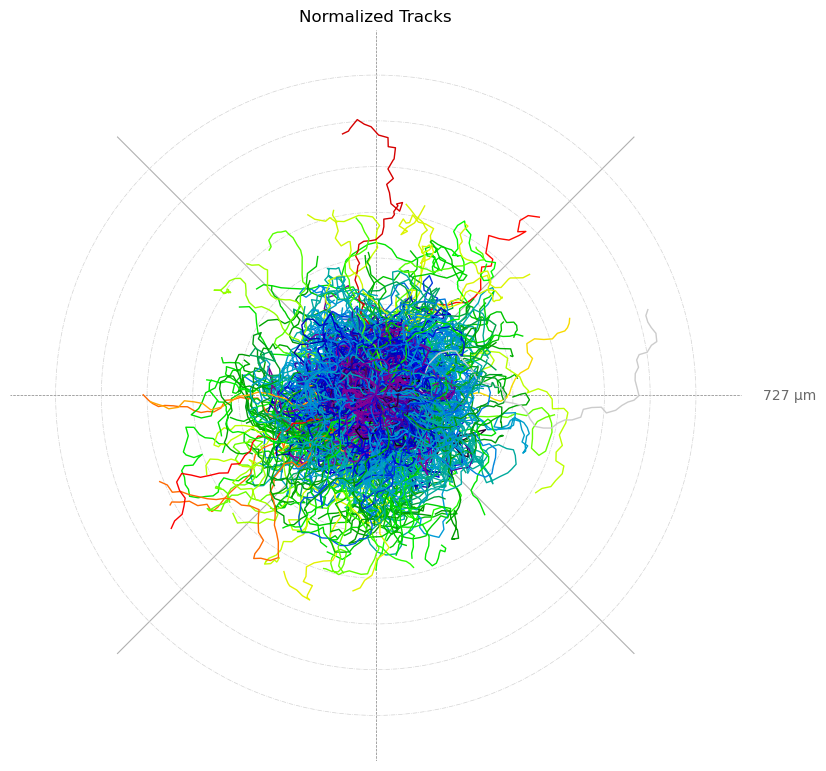

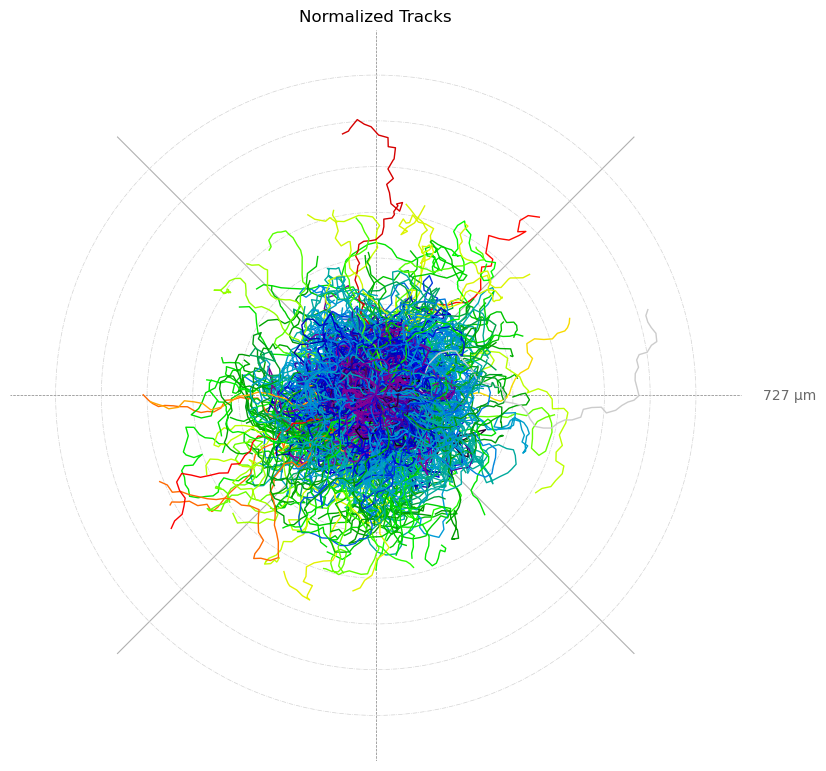

: 

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

def _rand_hex_colors(n, rng):
    return [mcolors.to_hex(rng.random(3)) for _ in range(n)]

def _rand_hex_greys(n, rng):
    greys = rng.random(n)
    return [mcolors.to_hex((float(g), float(g), float(g))) for g in greys]

def Visualize_normalized_tracks_matplotlib(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    condition: str,
    *args,
    replicate: str = 'all',
    c_mode: str = 'differentiate replicates',
    only_one_color: str = 'blue',
    lut_scaling_metric: str = 'Track displacement',
    smoothing_index: float = 0,
    lw: float = 1.0,
    show_tracks: bool = True,
    grid: bool = True,
    arrows: bool = False,
    arrowsize: int = 5,
):
    # ----------------- copies / guards -----------------
    Spots_all = Spots_df.copy()
    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()

    required_spots = ['Condition','Replicate','Track ID','Time point','X coordinate','Y coordinate']
    if any(col not in Spots.columns for col in required_spots):
        return plt.gcf()

    # ----------------- filter subset to draw -----------------
    if condition == 'all':
        if replicate != 'all':
            Spots = Spots.loc[Spots['Replicate'] == replicate]
            Tracks = Tracks.loc[Tracks['Replicate'] == replicate]
    else:
        Spots = Spots.loc[Spots['Condition'] == condition]
        Tracks = Tracks.loc[Tracks['Condition'] == condition]
        if replicate != 'all':
            Spots = Spots.loc[Spots['Replicate'] == replicate]
            Tracks = Tracks.loc[Tracks['Replicate'] == replicate]

    sort_cols = ['Condition','Replicate','Track ID','Time point']
    key_cols = ['Condition','Replicate','Track ID']
    Spots = Spots.sort_values(sort_cols).set_index(key_cols, drop=True)
    Tracks = Tracks.sort_values(['Condition','Replicate','Track ID']).set_index(key_cols, drop=True)

    # ----------------- smoothing (subset) -----------------
    if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
        win = int(smoothing_index)
        Spots['X coordinate'] = Spots.groupby(level=key_cols)['X coordinate'] \
            .transform(lambda s: s.rolling(win, min_periods=1).mean())
        Spots['Y coordinate'] = Spots.groupby(level=key_cols)['Y coordinate'] \
            .transform(lambda s: s.rolling(win, min_periods=1).mean())

    # ----------------- normalize (subset) -----------------
    x0 = Spots.groupby(level=key_cols)['X coordinate'].transform('first')
    y0 = Spots.groupby(level=key_cols)['Y coordinate'].transform('first')
    Spots['Xn'] = Spots['X coordinate'] - x0
    Spots['Yn'] = Spots['Y coordinate'] - y0

    # ----------------- colors on Tracks, join to Spots -----------------
    rng = np.random.default_rng(42)
    track_index = Tracks.index.unique()

    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        if c_mode == 'random colors':
            cols = _rand_hex_colors(len(track_index), rng)
        elif c_mode == 'random greys':
            cols = _rand_hex_greys(len(track_index), rng)
        else:
            cols = [mcolors.to_hex(only_one_color)] * len(track_index)
        Tracks['Track color'] = [dict(zip(track_index, cols))[idx] for idx in Tracks.index]

    elif c_mode == 'differentiate replicates':
        if 'Replicate color' in Tracks.columns:
            Tracks['Track color'] = Tracks['Replicate color'].astype(str)
        else:
            reps = Tracks.reset_index()['Replicate'].unique().tolist()
            rep_cols = _rand_hex_colors(len(reps), rng)
            rep2col = dict(zip(reps, rep_cols))
            Tracks = Tracks.reset_index()
            Tracks['Track color'] = Tracks['Replicate'].map(rep2col)
            Tracks = Tracks.set_index(key_cols)

    else:
        cmap = _get_cmap(c_mode)
        vmin = float(Tracks[lut_scaling_metric].min()) if lut_scaling_metric in Tracks.columns else 0.0
        vmax = float(Tracks[lut_scaling_metric].max()) if lut_scaling_metric in Tracks.columns else 1.0
        norm = plt.Normalize(vmin, vmax)
        vals = Tracks[lut_scaling_metric].to_numpy() if lut_scaling_metric in Tracks.columns else np.zeros(len(Tracks))
        Tracks['Track color'] = [mcolors.to_hex(cmap(norm(v))) for v in vals]

    Spots = Spots.join(Tracks[['Track color']], on=key_cols, how='left', validate='many_to_one')

    # ----------------- polar conversion (subset) -----------------
    Spots['r'] = np.sqrt(Spots['Xn']**2 + Spots['Yn']**2)
    Spots['theta'] = np.arctan2(Spots['Yn'], Spots['Xn'])

    # ----------------- GLOBAL y_max from full dataset -----------------
    All = Spots_all.sort_values(sort_cols).set_index(key_cols, drop=True)
    if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
        win = int(smoothing_index)
        AllX = All.groupby(level=key_cols)['X coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        AllY = All.groupby(level=key_cols)['Y coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
    else:
        AllX, AllY = All['X coordinate'], All['Y coordinate']
    AllX0 = AllX.groupby(level=key_cols).transform('first')
    AllY0 = AllY.groupby(level=key_cols).transform('first')
    All_r = np.sqrt((AllX - AllX0)**2 + (AllY - AllY0)**2)

    y_max_global = float(np.nanmax(All_r.to_numpy())) if len(All_r) else 1.0
    if not np.isfinite(y_max_global) or y_max_global <= 0:
        y_max_global = 1.0
    y_max = y_max_global * 1.1  # headroom

    # ----------------- segments (subset) -----------------
    segments, seg_colors = [], []
    for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
        th = g['theta'].to_numpy(dtype=float, copy=False)
        rr = g['r'].to_numpy(dtype=float, copy=False)
        if th.size >= 2:
            segments.append(np.column_stack([th, rr]))
            seg_colors.append(g['Track color'].iloc[0])

    # ----------------- figure / axes -----------------
    fig, ax = plt.subplots(figsize=(12.5, 9.5), subplot_kw={'projection': 'polar'})
    ax.set_facecolor('white')
    ax.set_title('Normalized Tracks', fontsize=12)
    ax.set_ylim(0, y_max)        # <- global, consistent across subsets
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(grid)

    # ----------------- draw tracks -----------------
    if segments:
        lc = LineCollection(segments, colors=seg_colors, linewidths=lw if show_tracks else 0, zorder=10)
        lc.set_transform(ax.transData)
        ax.add_collection(lc)

    # ----------------- arrows (optional) -----------------
    if arrows and 'Direction mean (rad)' in Tracks.columns:
        arrow_length = 1.0
        last_pts = Spots.groupby(level=key_cols, sort=False).tail(1).reset_index()
        mean_dir = Tracks.reset_index()[key_cols + ['Direction mean (rad)','Track color']]
        merged = pd.merge(last_pts, mean_dir, on=key_cols, how='left', validate='one_to_one')
        xe, ye = merged['Xn'].to_numpy(), merged['Yn'].to_numpy()
        md = merged['Direction mean (rad)'].to_numpy()
        cols = merged['Track color'].astype(str).to_numpy()
        xt, yt = xe + arrow_length*np.cos(md), ye + arrow_length*np.sin(md)
        tail_r = np.sqrt(xe**2 + ye**2); tail_th = np.arctan2(ye, xe)
        tip_r  = np.sqrt(xt**2 + yt**2); tip_th  = np.arctan2(yt, xt)
        if tail_r.size:
            for col in np.unique(cols):
                m = (cols == col)
                for th0, r0, th1, r1 in zip(tail_th[m], tail_r[m], tip_th[m], tip_r[m]):
                    ax.annotate('', xy=(th1, r1), xytext=(th0, r0),
                                arrowprops=dict(arrowstyle='-|>', color=str(col),
                                                lw=lw if show_tracks else 0, mutation_scale=arrowsize),
                                annotation_clip=False)

    # ----------------- subtle grid cosmetics -----------------
    for i, line in enumerate(ax.get_xgridlines()):
        if i % 2 == 0:
            line.set_linestyle('--'); line.set_color('grey'); line.set_linewidth(0.5)
    for line in ax.get_ygridlines():
        line.set_linestyle('-.'); line.set_color('lightgrey'); line.set_linewidth(0.5)

    # ----------------- μm label on the side (no line) -----------------
    # Show the global radius (rounded) just outside the right edge, centered vertically.
    label_um = f"{int(np.round(y_max_global))} μm"
    ax.text(1.03, 0.5, label_um,
            transform=ax.transAxes, ha='left', va='center',
            fontsize=10, color='dimgray', clip_on=False)

    return plt.gcf()


Visualize_normalized_tracks_matplotlib(
    Spots_df=SPOTS_DATAFRAME,
    Tracks_df=TRACKS_DATAFRAME,
    condition=TRACKS_DATAFRAME['Condition'].unique()[5],
    c_mode='nipy-spectral LUT',
)

In [ ]:

def Lut_map(Tracks_df:pd.DataFrame, c_mode:str, lut_scaling_metric:str, metrics_dict:dict):

    lut_norm_df = Tracks_df[['Track ID', lut_scaling_metric]].drop_duplicates()

    # Normalize the Net distance to a 0-1 range
    lut_min = lut_norm_df[lut_scaling_metric].min()
    lut_max = lut_norm_df[lut_scaling_metric].max()
    norm = plt.Normalize(vmin=lut_min, vmax=lut_max)

    if c_mode not in ['random colors', 'random greys', 'only-one-color']:
        # Get the colormap based on the selected mode
        colormap = _get_cmap(c_mode)
    
        # Add a colorbar to show the LUT map
        sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
        sm.set_array([])
        # Create a separate figure for the LUT map (colorbar)
        fig_lut, ax_lut = plt.subplots(figsize=(2, 6))
        ax_lut.axis('off')
        cbar = fig_lut.colorbar(sm, ax=ax_lut, orientation='vertical', extend='both', shrink=0.85)
        cbar.set_label(metrics_dict[lut_scaling_metric], fontsize=10)

        plt.gcf()
    
    else:
        pass

: 

: 